<a href="https://colab.research.google.com/github/knail1/bayes/blob/main/HW4_ISYE_6420_Fall_2021_oansari3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## HW4
#### ISYE 6420 - Bayesian Stats 

#### Student: Omer Ansari (oansari3)
#### Date: 10/14/2021

#Q1

Metropolis: Bounded Normal Mean
===============================

Suppose that we have information that the normal mean $\theta$ is
bounded between $-m$ and $m$, for some known number $m$. In this case it
is natural that the support of the prior on $\theta$ is interval
$[-m,m]$.

A prior with interesting theoretical properties supported on $[-m,m]$ is
the Bickel-Levit prior:

$$\pi(\theta)  = \frac{1}{m} \cos^2 \left(  \frac{\pi \theta}{2 m}   \right), \ \ -m \leq \theta \leq m$$

Assume that a sample $[-2,-3,4,-7,0,4]$ is observed from the normal
distribution

$$f(y|\theta)  \propto \tau \exp \left\{   -\frac{\tau}{2} (y-\theta)^2   \right\}$$

with known precision $\tau=1/4$. This combination of likelihood/prior
does not result in an explicit posterior in terms of elementary
functions. Construct the Metropolis algorithm that will sample from the
posterior of $\theta$.

Suggestions:

1.  Take the uniform distribution on $[-m,m]$ as a proposal distribution
    since it is easy to sample from. This is an independence proposal,
    since the proposed $\theta'$ does not depend on the current value of
    the chain, $\theta$.

2.  You will need to calculate $\sum_{i=1}^n (y_i-\theta)^2$ for current
    $\theta$ and $\sum_{i=1}^n (y_i-\theta')^2$ for the proposed
    $\theta'$, prior to calculating the Metropolis ratio.

    ----
    

### information provided:

- normal mean $\theta$ is bounded: $-m \le \theta \le$ m
- we can elicit a prior on $\theta$ on interval [-m, m]
- prior (generic) $\pi(\theta) = \frac{1}{m}cos^{2}\left ( \frac{\pi\theta}{2m} \right )$, for $-m \le \theta \le m $
- prior (specific, with m = 2) 
  - $\pi(\theta) = \frac{1}{4}cos^{2}\left ( \frac{\pi\theta}{4} \right )$ , $-2 \le \theta \le 2 $ --- **A.1**
- likelihood generic, (normal distribution): $f(y|\theta) \propto \sqrt{\tau}e^{\left ( \frac{\tau}{2}(y-\theta)^{2} \right )}$ 
- likelihood (specific for $\tau = \frac{1}{4}$:): $f(y|\theta) \propto \frac{1}{2}e^{\left ( \frac{1}{2}(\frac{y-\theta}{2})^{2} \right )}$ --- **A.2**
  - now, the standard normal distribution definition is:
  $N = \frac{1}{\sqrt{2\pi}\sigma}e^{-0.5\frac{{(y_{i}-\theta)}^{2}}{\sigma^{2}}}$  --- **A.3**
  - comparing A.2 and A.3 we can infer in our example, $\sigma = 2$ --- **A.4**

- data observed are multiple points:
  - $[-2,3,4,-7,0,4]$
  - therefore, we need to find a joint likelihood that each of these iid values took place one after the other.
  
  - Joint likelihood is:
  - $\mathscr{L} = \prod_{i=1}^{n}N$  
  - $= \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}\sigma}e^{-0.5\frac{{(y_{i}-\theta)}^{2}}{\sigma^{2}}}$ , or simplified to:
  -   - $\mathscr{L} = \propto \frac{1}{\sigma^{n}}e^{-0.5\sum_{i=1}^{n}{(\frac{{y_{i}-\theta}}{\sigma})}^{2}}$ ---- **A.5**



**(a) Simulate 10,000 observations from posterior, burn-in = 500, and plot histogram**

## ANSWER1:

Metropolis steps:
- **Step 1:** proposal initial (seed) value of $\theta$ from the posterior distrution.
  - here, we propose 1, which is a safe value between [-2,2]
- **Step 2:**  calculate the posterior density of observing the data using the initial seed proposal, by finding
    - (2a) the likelihood (or joint likelihood in our case since we have multiple observed values)
    - (2b) the prior, and then
    - (2c) the posterior, from *posterior $\propto$ likelihood ∗ prior*
    - we will call it $P(\theta_{current}|data)$. This is the posterior density value for a particular hypothesis of $\theta$.
- **Step 3:**  propose a *2nd* value of $\theta$ drawn , at random from a uniform distribution on [-m,m]
- **Step 4:** calculate posterior density for this random proposal (same steps as step 2)
   - lets call it $P(\theta_{proposed}|data)$
- **Step 5:** calculate the probabilty of accepting the proposal as $$min(\frac{\theta_{proposed}}{\theta_{current}},1)$$
- **Step 6:**  decide to accept proposal or stay put *randomly* (aka monte carlo), by pulling a random number from U(0,1) and comparing with value in Step5.
  - if our random number is less than step5, accept the proposal
  - if our random number is higher than step5, keep the original theta
- **Step 7:** repeat this experiment 10,000 times, and keep storing the thetas
- **Step 8:** drop the first 500 thetas (burn-ins)


in the code below, we now implement these steps.

In [15]:

import numpy as np
import pandas as pd
import random
from math import e, pi, cos
import matplotlib.pyplot as plt


def joint_likelihood(data_array,theta,tau):
  # as shown in A.5 above:
  sigma = 1/(tau**(0.5)) # first change tau to sigma
  n = len(data_array)
  term1 = 1/(sigma**(n))
  exponent_term1 = -0.5
  exponent_term2 = 0
  for value in data_array:
      exponent_term2 = exponent_term2 + ((value - theta)/sigma)**2

  term2 = e**(exponent_term1*exponent_term2)
  jl = term1*term2
  return jl 

def prior(theta,m):
  term1 = 1/m
  numerator_term2 = pi*theta
  denominator_term2 = 2*m
  term2 = (cos(numerator_term2/denominator_term2))**2
  return term1*term2

def draw_random_proposal(m):
  return random.uniform(-m,m)
  
def prob_of_accepting_proposal(p_current,p_proposed):
  #probability of moving to the proposal value:
  paccept = min(p_proposed/p_current, 1)
  return paccept

def decide_to_accept(paccept):
  random_val = random.uniform(0,1)
  #scale it down. 1/(b-a), b=2, a = -2, thus scale factor is 1/4
  random_val = 0.25*random_val
  #print("[decide_to_accept] random_val = {}".format(random_val))
  if paccept > random_val:
    decision = 1  
  else:
    decision = 0
  # 0 is dont accept proposal 1 is yes, accept proposal
  return decision


### reset constants and observed data

random.seed(42) 
thetas = []
m = 2
tau = 1/4
data = [-2,-3,4,-7,0,4]




theta_proposal_0 = 1 # step 1 initial value
thetas.append(theta_proposal_0)
jl_0 = joint_likelihood(data,theta_proposal_0,tau)  #step 2a

prior_0 = prior(theta_proposal_0,m) # step 2b
posterior_0 = jl_0*prior_0  # step 2c

theta_proposal_1 = draw_random_proposal(m) #step3 

posterior_1 = joint_likelihood(data,theta_proposal_1,tau) * prior(theta_proposal_1,m) #step4
paccept = prob_of_accepting_proposal(posterior_0, posterior_1) #step5
decision = decide_to_accept(paccept) # step6
if decision == 1: #step 7
  thetas.append(theta_proposal_1)
else: 
  thetas.append(theta_proposal_0)
print("~~~ First we step through the algorithm manually for one iteration to illustrate ~~~ ")
print("Step1: initial theta = {}".format(theta_proposal_0))
print("Step2: posterior density for initial theta:")
print("\tStep2a: joint-likelihood = {}".format(jl_0))
print("\tStep2b: prior = {}".format(prior_0))
print("\tStep2c: posterior density for 1st initial theta = {}".format(posterior_0))

print("Step3: draw a random proposal for theta from U(-2,2) = {}".format(theta_proposal_1))
print("Step4: posterior density for randomly proposed theta = {}".format(posterior_1))

print("Step5: probability of accepting proposal or keeping prior using acceptance ratio = {}".format(paccept))
print("Step6: decide to accept? 1 is yes, 0 is no = {}".format(decision))
print("Step7: add the theta (the proposal or the prior one) into the array of thetas")
print("repeat Steps 3 - 7 10,000 times")

~~~ First we step through the algorithm manually for one iteration to illustrate ~~~ 
Step1: initial theta = 1
Step2: posterior density for initial theta:
	Step2a: joint-likelihood = 2.1421235724751333e-08
	Step2b: prior = 0.25000000000000006
	Step2c: posterior density for 1st initial theta = 5.355308931187834e-09
Step3: draw a random proposal for theta from U(-2,2) = 0.557707193831535
Step4: posterior density for randomly proposed theta = 2.2917900251544425e-08
Step5: probability of accepting proposal or keeping prior using acceptance ratio = 1
Step6: decide to accept? 1 is yes, 0 is no = 1
Step7: add the theta (the proposal or the prior one) into the array of thetas
repeat Steps 3 - 7 10,000 times


~~~ Now we reset all values, and iterate through the algorithm 10,000 times, and plotting histogram ~~~ 
Average Theta: -0.25013233174202476


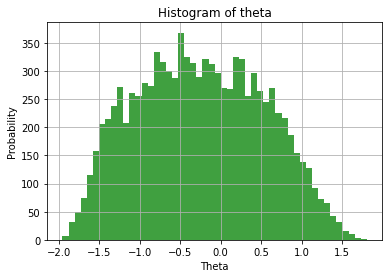

In [16]:
print("~~~ Now we reset all values, and iterate through the algorithm 10,000 times, and plotting histogram ~~~ ")


random.seed(42) 
theta = 1; #step1
iterations = 10500 # we will discard 500 of these;
m = 2
tau = 1/4
data = [-2,-3,4,-7,0,4]

thetas = [theta]

for i in range(iterations):
  posterior_current = joint_likelihood(data,theta, tau)*prior(theta,m) #step2
  theta_proposed = draw_random_proposal(m) # step3
  posterior_proposed = joint_likelihood(data,theta_proposed, tau)*prior(theta_proposed,m) #step4
  if decide_to_accept(prob_of_accepting_proposal(posterior_current, posterior_proposed)): #steps 5 and 6
    # if 1, then we accept the proposal:
    theta = theta_proposed
  #else we don't (theta remains unchanged, aka the current value) 
  thetas.append(theta) #step 7

thetas_keep = thetas[501:] # dropping 500 along with th initial seed theta

avg_theta = np.average(thetas_keep)
print("Average Theta: {}".format(avg_theta))

# the histogram of the data
n, bins, patches = plt.hist(thetas_keep, bins=50, facecolor='green', alpha=0.75)


plt.xlabel('Theta')
plt.ylabel('Probability')
plt.title('Histogram of theta')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()



----
**(1b) Find Bayes estimator of $\theta$ and 95% equitailed credible set based on simulated observations**



In [17]:
left_edge = np.percentile(thetas_keep , 2.5)
right_edge = np.percentile(thetas_keep , 97.5)
print("Bayes estimator (mean of kept thetas) = {}".format(avg_theta))
print("95% equitailed credible set is [{} {}]".format(left_edge, right_edge))

Bayes estimator (mean of kept thetas) = -0.25013233174202476
95% equitailed credible set is [-1.5958848649860726 1.1973144153253632]


-----
#Q2
Armitage and Berry (1994, p. 111) report data on the weight gain of 19
female rats between 28 and 84 days after birth. The rats were placed on
diets with high (12 animals) and low (7 animals) protein content:


    High protein   Low protein
  -------------- -------------
             134            70
             146           118
             104           101
             119            85
             124           107
             161           132
             107            94
              83 
             113 
             129 
              97 
             123 

We want to test the hypothesis on dietary effect. Did a low protein diet
result in significantly lower weight gain?

The classical $t$ test against one sided alternative will be
significant. We will do the test the Bayesian way using the Gibbs
sampler.

Assume that high-protein diet measurements $y_{1i}, \ i=1,\ldots,12$ are
coming from a normal distribution $N(\theta_1, 1/\tau_1)$, where
$\tau_1$ is the precision parameter:

$$f(y_{1i} |\theta_1, \tau_1  )  \propto  \tau_1^{1/2} \exp \left\{ -\frac{\tau_1}{2} (y_{1i} - \theta_1)^2  \right\}   ,  \ \ i=1,\ldots,12$$

Low-protein diet measurements $y_{2i}$, $i=1,\ldots,7$ are coming from a
normal distribution given as $N(\theta_2,1/\tau_2)$:

$$f(y_{2i} |\theta_2, \tau_2  )  \propto  \tau_2^{1/2} \exp \left\{ -\frac{\tau_2}{2} (y_{2i} - \theta_2)^2  \right\}   ,  \ \ i=1,\ldots,7$$

Assume that $\theta_1$ and $\theta_2$ have normal priors
$N(\theta_{10}, 1/\tau_{10})$ and $N(\theta_{20}, 1/\tau_{20})$
respectively. Take prior means as $\theta_{10}=\theta_{20}=110$ (apriori
no preference) and precisions as $\tau_{10}=\tau_{20}=1/100$.

Assume that $\tau_{1}$ and $\tau_{2}$ have the gamma $Ga(a_1,b_1)$ and
$Ga(a_2,b_2)$ priors with shapes $a_1=a_2=0.01$ and rates $b_1=b_2=4$.

**1.  Construct Gibbs sampler that will sample $\theta_1$, $\tau_1$, $\theta_2$, $\tau_2$ from their posteriors.**


-----


# ANSWER 2:

### goal and theory behind approach
- as always we want to estimate the posterior (in this case two posteriors , one for high protein diet, and one for low protein diet)
- each of the two is a multi-variate distribution. in each we have a $\theta$ and $\tau$.
- the gibbs sampler allows us to sample from the posterior distribution as a 'conditional' distribition, while keeping the other two variates as constant. 
- **evaluating $\theta$**: 
  - From provided gibbs.pdf we can extract the derivation the full conditional for \theta from the joint distribution of $f(y,\theta,\tau)$:
    - $\pi(\theta|\tau,y) \propto e^{-0.5(\tau_0 +n\tau)(\theta - \frac{\tau\sum y_{i}+\tau_0\theta_0}{\tau_0+n\tau})}$ -- **A.1**
  - A.1 is the kernel of a normal:
    - $N \left ( \frac{\tau\sum_{i=1}^{n}y_i + \tau_0\theta_0}{n\tau+\tau_0}, \frac{1}{n\tau+\tau_0} \right )$ -- **A.2**
  - note that x in N(x,y) above is mean, and y is *variance*

- **evaluating $\tau$**: 
  - From provided gibbs.pdf we can extract the derivation the full conditional for \theta from the joint distribution of $f(y,\theta,\tau)$:
    - $\pi(\tau|\theta,y) \propto \tau^{n/2+\alpha -1}e^{-\tau \left ( \frac{1}{2}\sum_{i=1}^{n}(y_i-\theta)^{2}+b \right )}$ -- **A.3**
  - A.3 is the kernel of a Gamma distribution:
    - $Ga(n/2 + \alpha, \frac{1}{2}\sum_{i=1}^{n}(y_i-\theta)^{2}+b)$ -- **A.4**

- the crux of this derivation hinges on finding the full conditional distribution for \theta by selecting the terms from $f(y,\theta,\tau)$ that contain $\theta$ and normalizing.
- gibbs allows us to estimate the joint posterior distribution of $\theta$ by the fact that:
  - $\pi(\theta|\tau,y) = \frac{\pi(\theta,\tau|y)}{\pi(\tau|y)} = \frac{\pi(\theta,\tau,y)}{\pi(\tau,y)} \propto \pi(\theta\tau,y)$


### method in solving Q2:



- recall that we have two different posteriors ($\pi$) to derive
  - the high protein diet posterior
  - the low protein diet posterior

- for *each* of these posteriors, we have a multi-variate distribution. 
  - $\theta_1$ and $\tau_1$ for high-protein
  - $\theta_2$ and $\tau_2$ for low-protein
- we need to estimate the distributions of each of these *four* parameters.

- for *each* of these four, we will use Gibb's conditional sampling approach, and sample 10,500 values  and drop the first 500.
  - for $\theta_1$: $\pi(\theta_1|\tau_1,y)$ --**A.5 **, A.1 instance
  - for $\theta_2$: $\pi(\theta_2|\tau_2,y)$ --**A.6**, A.1 instance
  - for $\tau_1$: $\pi(\tau_1|\theta_1,y)$ --**A.7**, A.3 instance
  - for $\tau_2$: $\pi(\tau_2|\theta_2,y)$ --**A.8**, A.3 instance

- the trick we use for $\theta_1$ and $\theta_2$ is that since we already know that
  - the full conditional posterior is the **normal** distribution A.1 above, we can use the derived mean and variance for it (shown in A.2) to create this posterior.
- the trick we use for $\tau_1$ and $\tau_2$ is that since we already know that
  - the full conditional posterior is the **gamma** distribution A.3 above, we can use the derived mean and variance for it (shown in A.4) to create this posterior.

~~~~~ HIGH PROTEIN DISTRIBUTION CALCULATION: ~~~~~
mean of theta_1 = 116.94399991149926
mean of tau_1 = 0.0022114935589727866


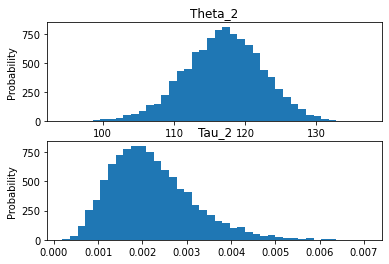




~~~~~ LOW PROTEIN DISTRIBUTION CALCULATION: ~~~~~
mean of theta_2 = 104.71951045866902
mean of tau_2 = 0.0024350778502226014


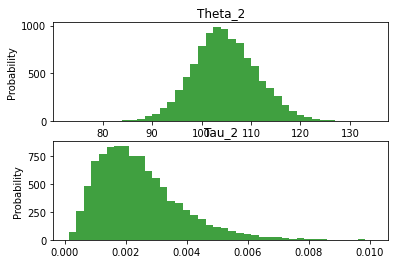

In [18]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)


print("~~~~~ HIGH PROTEIN DISTRIBUTION CALCULATION: ~~~~~")

high_protein_observations = np.array([134,146,104,119,124,161,107,83,113,129,97,123])


iterations = 10500;

# all variables suffixed with _1 (eg theta_1 and tau_1) are going to be the parameters for high protein dist
thetas_1 = np.array([])
taus_1 = np.array([])
n_1 = high_protein_observations.shape[0]

sumdata_high_protein = np.sum(high_protein_observations)
#hyperparameters (initial seeds)
theta_1_0=110
tau_1_0 = 1/100

a= 0.01
b= 4
# start, initial values
theta_1 =  0.5    
tau_1 = 0.5  


for i in range(iterations):
  ## implementing A.2:
  new_theta_1  = np.random.normal(
      (tau_1 * sumdata_high_protein + tau_1_0*theta_1_0)/(tau_1_0+n_1*tau_1),
      np.sqrt(1/(tau_1_0+n_1*tau_1))
  )  
  
  ## implementing A.4:
  rate_high_protein   = b + 1/2*np.sum((high_protein_observations -  theta_1)**2) 
  new_tau_1 = np.random.gamma(a + n_1/2, 1/rate_high_protein);  # note the 1/x in the 2nd term to accomodate python's gamma function requirement

  thetas_1 = np.append(thetas_1, new_theta_1)
  taus_1 = np.append(taus_1, new_tau_1)
  theta_1 = new_theta_1 # unlike metropolis, we always update our parameters
  tau_1 = new_tau_1 # same
 
 
burn =500 
thetas_1  = thetas_1[burn:iterations] 
taus_1 = taus_1[burn:iterations] 

print("mean of theta_1 = {}".format(np.mean(thetas_1)))
print("mean of tau_1 = {}".format(np.mean(taus_1)))



fig, ax = plt.subplots()
x1 = plt.subplot(2,1,1) 
plt.hist(thetas_1, 40)
x2 = plt.subplot(2,1,2) 
plt.hist(taus_1, 40)
x1.set(title="Theta_2", ylabel="Probability")
x2.set(title="Tau_2", ylabel="Probability")
plt.show()


#--------now we calculate the same for low protein distribution --------------
print("\n\n")
print("~~~~~ LOW PROTEIN DISTRIBUTION CALCULATION: ~~~~~")
low_protein_observations = np.array([70,118,101,85,107,132,94])
# all variables suffixed with _2 (eg theta_2 and tau_2) are going to be the parameters for low protein dist
n_2 = low_protein_observations.shape[0]
thetas_2 = np.array([])
taus_2 = np.array([])
theta_2_0=110
tau_2_0 = 1/100
a= 0.01
b= 4

sumdata_low_protein = np.sum(low_protein_observations)

# start, initial values
theta_2 =  0.5    
tau_2 = 0.5  


for i in range(iterations):
  ## implementing A.2:
  new_theta_2  = np.random.normal((
      tau_2 * sumdata_low_protein + tau_2_0*theta_2_0)/(tau_2_0+n_2*tau_2),
      np.sqrt(1/(tau_2_0+n_2*tau_2)))
  
  ## implementing A.4:
  rate_low_protein   = b + 1/2*np.sum((low_protein_observations -  theta_2)**2)
  new_tau_2 = np.random.gamma(a + n_2/2, 1/rate_low_protein);  # note the 1/x in the 2nd term to accomodate python's gamma function requirement

  thetas_2 = np.append(thetas_2, new_theta_2)
  taus_2 = np.append(taus_2, new_tau_2)
  theta_2 = new_theta_2 # unlike metropolis, we always update our parameters
  tau_2 = new_tau_2 # same
 
 
burn =500 
thetas_2  = thetas_2[burn:iterations] 
taus_2 = taus_2[burn:iterations] 

print("mean of theta_2 = {}".format(np.mean(thetas_2)))
print("mean of tau_2 = {}".format(np.mean(taus_2)))



fig, ax = plt.subplots()
x1 = plt.subplot(2,1,1) 
plt.hist(thetas_2, 40, facecolor='green', alpha=0.75)

x2 = plt.subplot(2,1,2) 
plt.hist(taus_2, 40, facecolor='green', alpha=0.75)

x1.set(title="Theta_2", ylabel="Probability")
x2.set(title="Tau_2", ylabel="Probability")

plt.show()







------
**2.  Find sample differences $\theta_1-\theta_2$. Proportion of positive differences approximates posterior probability of hypothesis $H_{0}: \theta_{1} > \theta_{2}$. What is this proportion?**



In [19]:
delta_theta = thetas_1-thetas_2
# identify the positive items:
delta_theta_positive = delta_theta[delta_theta > 0]
proportion = delta_theta_positive.shape[0]/delta_theta.shape[0]
print("The # of positive differences between Theta1-Theta2 = {}".format(delta_theta.shape[0]))
print("The proportion of positive differences of Theta1-Theta2 to all (kept) observations = {:.2%}".format(proportion))

The # of positive differences between Theta1-Theta2 = 10000
The proportion of positive differences of Theta1-Theta2 to all (kept) observations = 92.24%


------

**3.  Using sample quantiles find the 95% equitailed credibe set for $\theta_1-\theta_2$. Does this set contain $0$?**


In [20]:
sorted_delta = np.sort(delta_theta)
delta_theta
sorted_delta

left_edge = sorted_delta[250]
right_edge = sorted_delta[9750]
print("95th equitailed credible set: [{} {}]".format(left_edge,right_edge))

# alt method:

le2 = np.percentile(delta_theta , 2.5)
re2 = np.percentile(delta_theta , 97.5)
print("alt method: 95th equitailed credible set: [{} {}]".format(le2,re2))


95th equitailed credible set: [-5.221111637633612 28.706464605220177]
alt method: 95th equitailed credible set: [-5.221284391296641 28.694634575096536]


Yes as we can see the range of the credible set, the set contains 0.